In [40]:
import numpy as np
import pandas as pd
import numpy.random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline
numpy.random.seed(1239)

In [41]:
# Read the data
raw_data = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [42]:
#Check if any is nan. 
raw_data.isna().sum().sum()

0

In [43]:
def prepare_data(raw_data):
    labels = raw_data.Attrition == 'Yes'
    employee_data = raw_data.set_index('EmployeeNumber').drop(columns=['Attrition', 'EmployeeCount', 'Over18'])
    employee_data.loc[:, 'OverTime'] = employee_data.OverTime == 'Yes'
    employee_data = pd.get_dummies(employee_data)
    employee_data = pd.concat([employee_data.YearsAtCompany, employee_data.drop(columns='YearsAtCompany')], axis=1)
    return employee_data, labels


In [44]:
employee_data, labels = prepare_data(raw_data)
employee_data


,YearsAtCompany,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,6,41,1102,1,2,2,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
2,10,49,279,8,1,3,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
4,0,37,1373,2,2,4,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
5,8,33,1392,3,4,4,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
7,2,27,591,2,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0
8,7,32,1005,2,2,4,79,3,1,4,...,1,0,0,0,0,0,0,0,0,1
10,1,59,1324,3,3,3,81,4,1,1,...,1,0,0,0,0,0,0,0,1,0
11,1,30,1358,24,1,4,67,3,1,3,...,1,0,0,0,0,0,0,1,0,0
12,9,38,216,23,3,4,44,2,3,3,...,0,0,1,0,0,0,0,0,0,1


Now we want to generate synthetic labels to test if our models works in a controlled environment. Let's assume, that the probability that a person quits is a constant and does not depend on any features. In this case the likelihood that the person has quit follows a geometric distribution. If our model can correctly find this probability *p* based on a synthetic labels, then we can try this model on real data. 

In [45]:
#pick a p
p = 0.1

In [46]:
def quit_after(years, p):
    return numpy.random.rand(years.shape[0]) < (1-p)**(years-1)*p

In [69]:
synthetic_labels = quit_after(employee_data.YearsAtCompany, p).astype('float')

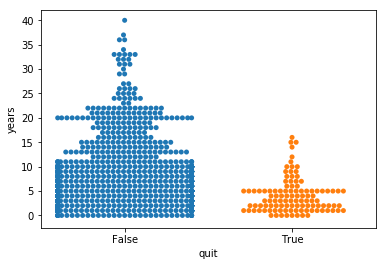

In [48]:
sns.swarmplot(y='years', x='quit', data=pd.DataFrame({"quit":synthetic_labels, 'years':employee_data.YearsAtCompany}))

Based on the chart it seems like a realistic data set.
Now we need to construct our loss function. It will have an additional parameter: number of years

We define probability $p(x, t)$ that the person quits this very day, where t is the number of years and x is the remaining features. Then the probabiity that the person has quit after the year $t$  is 
$$P(x,t) = (\prod_{l=0}^{t-1} (1-p(x,l))) p(x,t) $$ whereas the probability that the person will remain after the year $t$ is 
$$P(x,t) = \prod_{l=0}^{t} (1-p(x,l)) $$
Strictly speaking x is also dependent on t, but we don't have the historical data for this, so we assume that x is independent of t.

Using the principle of maximum likelihood, we derive the loss function taking negative log of the likelihood function:
$$\mathscr{L}(y,p) = -\sum_{l=0}^{t-1} \log{p(x,l)} - y \log{p} - (1-y) \log(1-p) $$
Where y is an indicator if the person has quit after working exactly t years or not.
Notice that the last two terms is the cross-entropy loss function, and the first term is a hitorical term. 

Let's calculate the gradient of this function
$$ \frac{\partial \mathscr L}{\partial p} = -\sum_{l=0}^{t-1} \frac{1}{p(x,l)} -\frac{y}{p} + \frac{1-y}{1-p}$$

Assuming that $p(x,l)$ is a sigmoid function (for simplicity we include bias in the list of weights, and so the weight for the t parameter): $$p=\frac{1}{1 + e^{-\bf{w}\bf{x}}}$$
Then the derivative over parameter becomes (once we remove the constant) for the x other than t:
$$ \frac{\partial \mathscr L}{\partial w_i} = -(\sum_{l=0}^{t-1} p(x,l) + p - y) * x_i $$
The gradient for the weight corresponding to t is
$$ \frac{\partial \mathscr L}{\partial w_t} = -\sum_{l=0}^{t-1} p(x,l)l + (p - y) * t $$




In [49]:
### WE WILL TRY TO DO THIS IN TENSORFLOW. If not successful we will implement gradient descent manually

In [50]:
# num_features = employee_data.values.shape[1]

# #Create placeholders
# X = tf.placeholder(tf.float32, shape=[num_features, None], name="X")
# targets = tf.placeholder(tf.float32, shape=[1, None], name="Y")

# #Create variables
# W = tf.get_variable("W", shape=[num_features], initializer = tf.zeros_initializer())
# b = tf.get_variable("b", 0)


In [51]:
def sigmoid(z):
    return 1 (1 + np.exp(-z))

In [52]:
#Add 1 to the employee data
employee_data['Ones'] = np.ones(shape=[employee_data.shape[0]])

In [53]:
def logit(x, w, k=None):
    #We assume that YearsAtCompany is the first feature
    return x @ w + ((k-x[0]) * w[0] if k != None else 0)

In [54]:
def loss(x, y, w):
    #The first term
    sum_loss = 0
    for l in range(x[0]):
        sum_loss -= np.log(sigmoid(logit(x, w, l)))
    logistic_prob = sigmoid(logit(x, w))
    return sum_loss - y * np.log(logistic_prob) - (1-y) * np.log(1-logistic_prob)

In [55]:
def gradient(x,y,w):
    sum_prop = 0
    weighted_sum
    for l in range(x[0]):
        sum_prop += sigmoid(logit(x, w, l)) 
        weighted_sum += sigmoid(logit(x, w, l)) * l
    grad =  -(sum_prop + sigmoid(x, w) - y) * x
    grad[0] = -weighted_sum - (sigmoid(x, w) - y) * x[0]
    return grad
    

In [73]:
def one_pass(weights, step_size):
    cost = 0
    gradient = np.zeros(shape=employee_data.shape[1])
    for i in range(employee_data.shape[0]):
        cost += loss(employee_data.values[i], synthetic_labels.values[i], weights)
        gradient += loss(employee_data.values[i], synthetic_labels[i], weights)
    print('Cost: ' + cost)
    return weights - step_size * gradient
        

In [74]:
#Initialize weights
weights = np.zeros(shape=[employee_data.values.shape[1]])
epochs = 4
step = 0.1
for epoch in range(epochs):
    weights = one_pass(weights, step)
print(weights)

TypeError: Object arrays are not currently supported

In [72]:
synthetic_labels.describe()

count    1470.000000
mean        0.059864
std         0.237315
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: YearsAtCompany, dtype: float64